<a href="https://colab.research.google.com/github/ShannonH98/PyTorch_Practice_Projects/blob/main/MRI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Project

# 1. Import packeges and setup environment

In [1]:
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
#clear cache

In [2]:
!pip install tensorflow
!pip install kaggle

In [38]:
import os
import numpy as np
import time
import timeit
import datetime
import random
import matplotlib.pyplot as plt
import json
import random #to get random values for data aumentation
from PIL import Image, ImageEnhance
from pathlib import Path
from tensorflow.keras.callbacks import TensorBoard
#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')
#to save models to later

models = Path("/content/gdrive/MyDrive/models")
models.mkdir(parents=True, exist_ok=True)


print(f"Folder created at: {models}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder created at: /content/gdrive/MyDrive/models


In [39]:
logs = Path(
    "/content/drive/MyDrive/tensorboard_logs/"
    f"model_m1_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
)

logs.mkdir(parents=True, exist_ok=True)

tb_callback = TensorBoard(log_dir=str(logs))


In [11]:
os.environ["KAGGLE_API_TOKEN"] = "KGAT_52fddb516f9208194dc39c7e55d41f9d"

In [12]:
# Save token in the format Kaggle expects
kaggle_config = {
    "username": "YOUR_KAGGLE_USERNAME",  # replace with your Kaggle username
    "key": os.environ["KAGGLE_API_TOKEN"]
}

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_config, f)

!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset #get dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 85% 126M/149M [00:00<00:00, 1.31GB/s]
100% 149M/149M [00:00<00:00, 1.17GB/s]


In [14]:
!mkdir -p /content/drive/MyDrive/mri_data
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/drive/MyDrive/mri_data


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 130M/149M [00:00<00:00, 1.35GB/s]
100% 149M/149M [00:00<00:00, 1.24GB/s]


In [15]:
!unzip /content/drive/MyDrive/mri_data/brain-tumor-mri-dataset.zip -d /content/drive/MyDrive/mri_data


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0723.jpg  
  inflating: 

In [16]:
!ls drive/MyDrive/mri_data

brain-tumor-mri-dataset.zip  Testing  Training


In [17]:
print(os.listdir("/content"))

['.config', 'brain-tumor-mri-dataset.zip', 'drive', 'gdrive', 'sample_data']


In [18]:
#split train and rest directory
train_dir = '/content/drive/MyDrive/mri_data/Training'
test_dir = '/content/drive/MyDrive/mri_data/Testing'

In [19]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  print(label)

pituitary
glioma
notumor
meningioma


In [20]:
for label in os.listdir(train_dir):
  for image in os.listdir(train_dir + '/' + label):
    train_paths.append(train_dir + '/' + label + '/' + image)
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

train_paths

['/content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0293.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_0249.jpg',
 '/content/drive/MyDrive/mri_data/Training/pituitary/Tr-pi_0709.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_0042.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_0432.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_1502.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_0406.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_0044.jpg',
 '/content/drive/MyDrive/mri_data/Training/pituitary/Tr-pi_0972.jpg',
 '/content/drive/MyDrive/mri_data/Training/pituitary/Tr-pi_1380.jpg',
 '/content/drive/MyDrive/mri_data/Training/pituitary/Tr-pi_0713.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_1316.jpg',
 '/content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0500.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_0943.jpg',
 '/content/drive/MyDrive/mri_data

In [21]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  print(label)

pituitary
glioma
notumor
meningioma


In [22]:
for label in os.listdir(test_dir):
  for image in os.listdir(test_dir + '/' + label):
    test_paths.append(test_dir + '/' + label + '/' + image)
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

test_paths

['/content/drive/MyDrive/mri_data/Testing/meningioma/Te-me_0106.jpg',
 '/content/drive/MyDrive/mri_data/Testing/meningioma/Te-me_0246.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0245.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0115.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0094.jpg',
 '/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0274.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0085.jpg',
 '/content/drive/MyDrive/mri_data/Testing/meningioma/Te-me_0035.jpg',
 '/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0077.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0216.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0135.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0265.jpg',
 '/content/drive/MyDrive/mri_data/Testing/meningioma/Te-me_0121.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0085.jpg',
 '/content/drive/MyDrive/mri_data/Testing/notumor

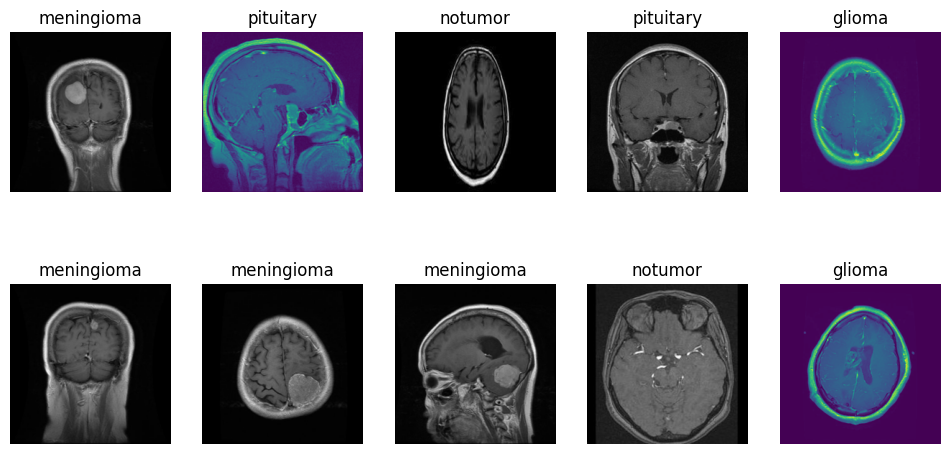

In [23]:
#random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

#create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

#loop through the random indices and display images
for i, idx in enumerate(random_indices):
  img = load_img(train_paths[idx])
  img = Image.open(train_paths[idx])
  img = img.resize((224, 224))
  axes[i].imshow(img)
  axes[i].set_title(train_labels[idx])
  axes[i].axis('off')

In [24]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Model 1 - VGG16

In [41]:
# Model architecture
start = time.perf_counter()
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False


base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model_m1 = Sequential()
model_m1.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model_m1.add(base_model)
model_m1.add(Flatten())
model_m1.add(Dropout(0.3))
model_m1.add(Dense(128, activation='relu'))
model_m1.add(Dropout(0.2))
model_m1.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compile the model
model_m1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history_m1 = model_m1.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs
),
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[tb_callback]
)

end = time.perf_counter()
time_m1 = end - start

time_m1

Epoch 1/5
266/285 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 0.6248 - sparse_categorical_accuracy: 0.7476

KeyboardInterrupt: 

In [ ]:
model_m1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,021,198 (122.15 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 16,257,290 (62.02 MB)

In [ ]:
hours = int(time_m1 // 3600)
minutes = int((time_m1 % 3600) // 60)
secs = time_m1 % 60

print(f"{hours}h {minutes}m {secs:.2f}s")

1h 38m 44.67s


NameError: name 'history_m1' is not defined

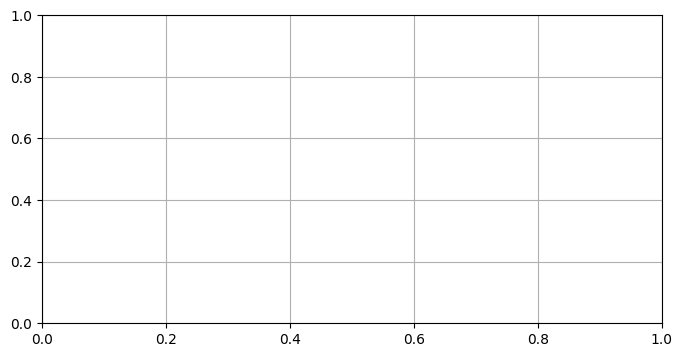

In [29]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_m1.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_m1.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

#test_predictions = model_m1.predict(test_images)

def evaluate_model(model, test_images, test_labels, model_name="Model"):
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    print(f"\nClassification Report – {model_name}")
    print(classification_report(test_labels, predicted_classes))

#evaluate_model(model_m1, test_images, test_labels_encoded, "VGG16")

In [ ]:
evaluate_model(model_m1, test_images, test_labels_encoded, "VGG16")

41/41 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step

Classification Report – VGG16
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       1.00      0.85      0.92       300
           2       0.99      0.99      0.99       405
           3       0.87      0.99      0.93       306

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [ ]:
# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model_m1.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       0.99      0.86      0.92       300
           2       0.99      1.00      0.99       405
           3       0.88      0.98      0.93       306

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[297   0   1   2]
 [  1 258   2  39]
 [  0   0 403   2]
 [  1   3   1 301]]


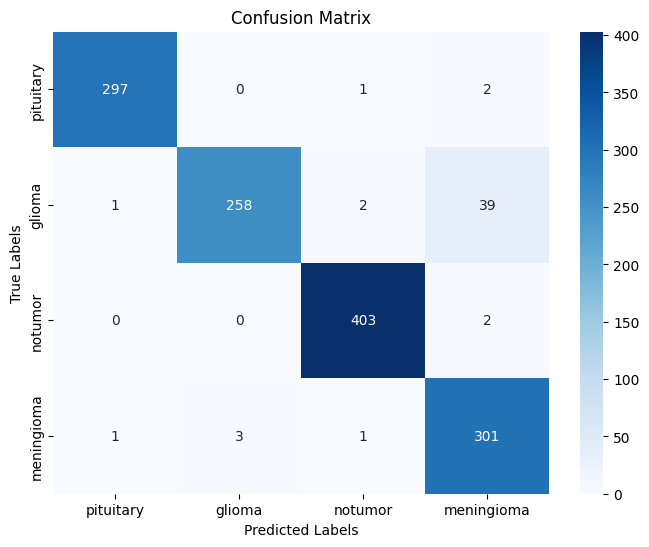

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

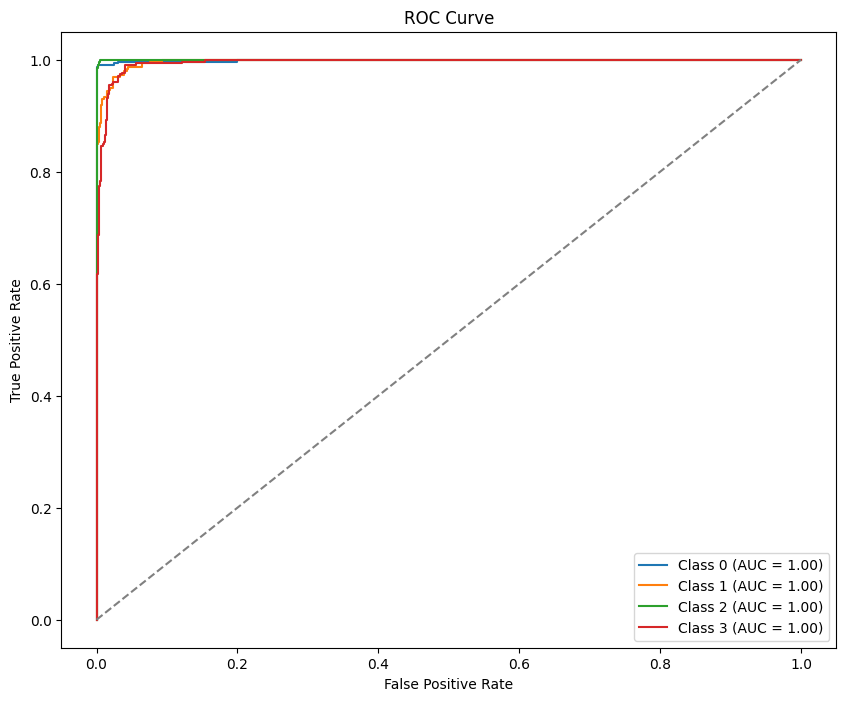

In [ ]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the entire model
#model_m1.save('model_m1.keras')
#model_m1 = 'model_m1.pth'

In [ ]:
model_path = models / 'model_m1.keras'
model_m1.save(model_path)
print(f"Model saved to: {model_path}")

Model saved to: models/model_m1.keras


In [ ]:
# Load the trained model
model_m1 = load_model('model_m1.keras')

In [ ]:
!ls /content/models

model_m1.keras


In [ ]:
!mv /content/models/model_m1.keras /content/gdrive/MyDrive/models/


In [ ]:
ls /content/gdrive/MyDrive/models

model_m1.keras


In [ ]:
# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [ ]:
#get sample image path

#ls /content/drive/MyDrive/mri_data/Testing/glioma
#ls /content/drive/MyDrive/mri_data/Testing/pituitary/
!ls /content/drive/MyDrive/mri_data/Testing/notumor/
#pick one

Te-no_0010.jpg	Te-no_0112.jpg	Te-no_0214.jpg	Te-no_0316.jpg
Te-no_0011.jpg	Te-no_0113.jpg	Te-no_0215.jpg	Te-no_0317.jpg
Te-no_0012.jpg	Te-no_0114.jpg	Te-no_0216.jpg	Te-no_0318.jpg
Te-no_0013.jpg	Te-no_0115.jpg	Te-no_0217.jpg	Te-no_0319.jpg
Te-no_0014.jpg	Te-no_0116.jpg	Te-no_0218.jpg	Te-no_0320.jpg
Te-no_0015.jpg	Te-no_0117.jpg	Te-no_0219.jpg	Te-no_0321.jpg
Te-no_0016.jpg	Te-no_0118.jpg	Te-no_0220.jpg	Te-no_0322.jpg
Te-no_0017.jpg	Te-no_0119.jpg	Te-no_0221.jpg	Te-no_0323.jpg
Te-no_0018.jpg	Te-no_0120.jpg	Te-no_0222.jpg	Te-no_0324.jpg
Te-no_0019.jpg	Te-no_0121.jpg	Te-no_0223.jpg	Te-no_0325.jpg
Te-no_0020.jpg	Te-no_0122.jpg	Te-no_0224.jpg	Te-no_0326.jpg
Te-no_0021.jpg	Te-no_0123.jpg	Te-no_0225.jpg	Te-no_0327.jpg
Te-no_0022.jpg	Te-no_0124.jpg	Te-no_0226.jpg	Te-no_0328.jpg
Te-no_0023.jpg	Te-no_0125.jpg	Te-no_0227.jpg	Te-no_0329.jpg
Te-no_0024.jpg	Te-no_0126.jpg	Te-no_0228.jpg	Te-no_0330.jpg
Te-no_0025.jpg	Te-no_0127.jpg	Te-no_0229.jpg	Te-no_0331.jpg
Te-no_0026.jpg	Te-no_0128.jpg	Te-no_0230

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


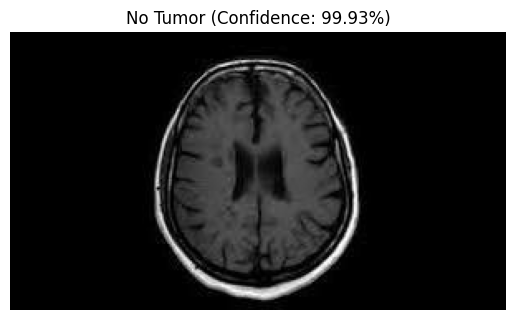

In [ ]:
image_path = '/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0201.jpg'  # Provide the path to your new image
detect_and_display(image_path, model_m1)

# denseNet

In [ ]:
IMAGE_SIZE = 128
start = time.perf_counter()
base_densenet_model =DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Freeze base model
base_densenet_model.trainable = False

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = data_augmentation(inputs)
x = base_densenet_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(os.listdir(train_dir)), activation='softmax')(x)

model_m2 = Model(inputs, outputs)


# Compile
model_m2.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model_m2.summary()

#Running with DenseNet
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history_m2 = model_m2.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

end = time.perf_counter()
time_m2 = end - start

time_m2

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - loss: 2.3313 - sparse_categorical_accuracy: 0.3192
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - loss: 1.1704 - sparse_categorical_accuracy: 0.5905
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.8731 - sparse_categorical_accuracy: 0.6853
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - loss: 0.7541 - sparse_categorical_accuracy: 0.7179
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - loss: 0.7059 - sparse_categorical_accuracy: 0.7363


1664.0732534939998

In [ ]:
hours = int(time_m2 // 3600)
minutes = int((time_m2 % 3600) // 60)
secs = time_m2 % 60

print(f"{hours}h {minutes}m {secs:.2f}s")

0h 27m 44.07s


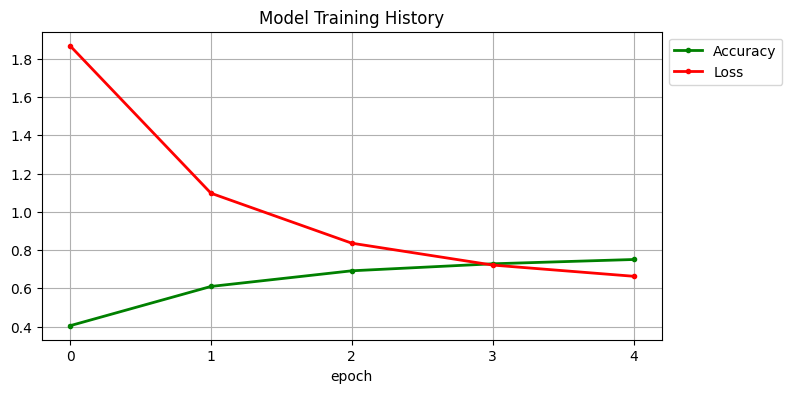

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_m2.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_m2.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
evaluate_model(model_m2, test_images, test_labels_encoded, "denseNet")

41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step

Classification Report – denseNet
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       300
           1       0.91      0.67      0.78       300
           2       0.87      0.91      0.89       405
           3       0.71      0.38      0.49       306

    accuracy                           0.75      1311
   macro avg       0.77      0.74      0.72      1311
weighted avg       0.78      0.75      0.74      1311



Confusion Matrix 2:
[[298   0   1   1]
 [ 50 199  10  41]
 [ 17  11 369   8]
 [125  12  49 120]]


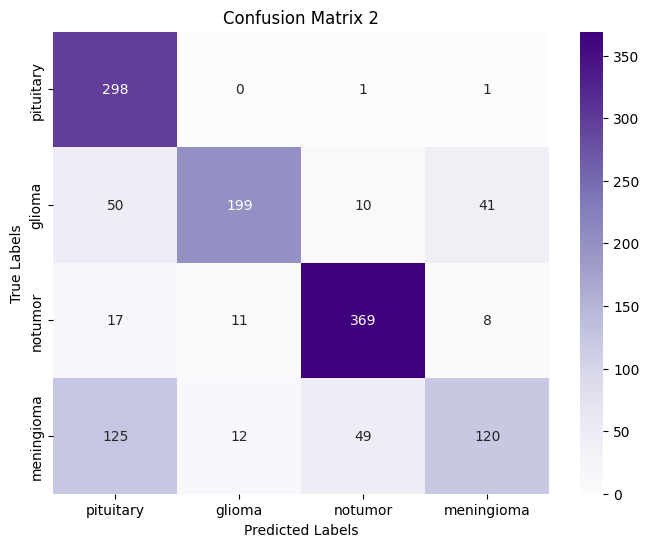

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix 2:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix 2")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

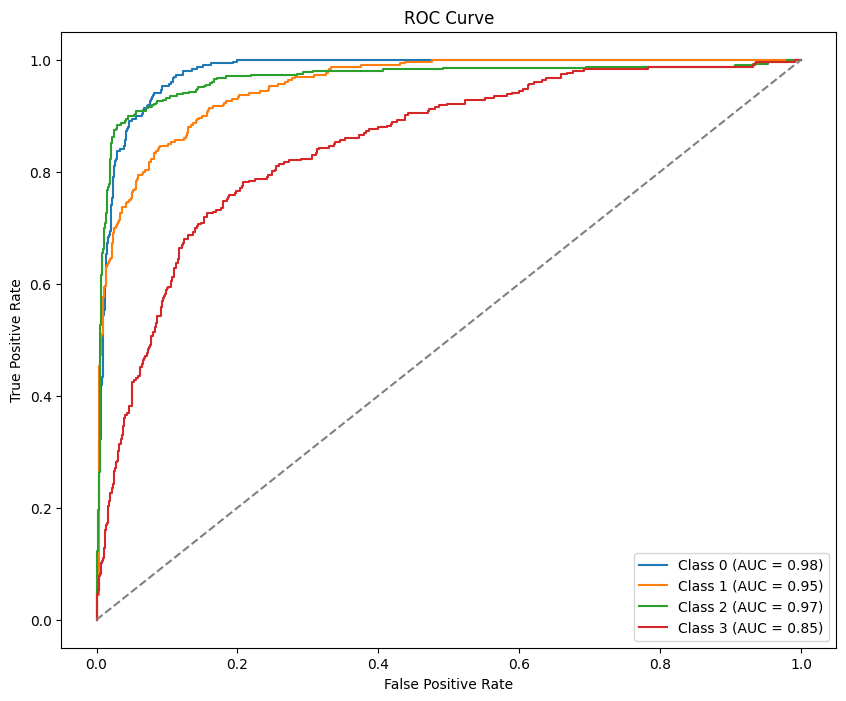

In [ ]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the entire model
model_m2.save('model2.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


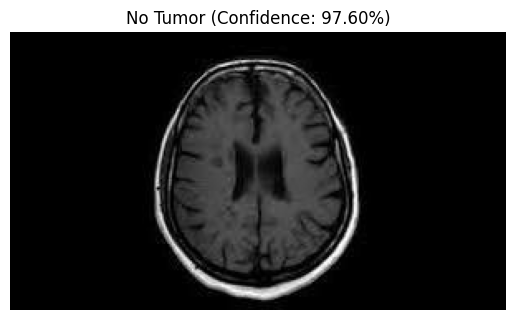

In [ ]:
image_path = '/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0201.jpg'  # Provide the path to your new image
detect_and_display(image_path, model_m2)

# ResNet50

In [ ]:
IMAGE_SIZE = 224
start = time.perf_counter()
model_m3 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=1000,
    classifier_activation='softmax'
)

#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
   layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = data_augmentation(inputs)
x = model_m3(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(os.listdir(train_dir)), activation='softmax')(x)


model_m3 = Model(inputs, outputs)


# Compile
model_m3.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model_m3.summary()

#Running with ResNet50
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history_m3 = model_m3.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

end = time.perf_counter()
time_m3 = end - start

time_m3

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 4398s 15s/step - loss: 0.6374 - sparse_categorical_accuracy: 0.7501
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 4327s 15s/step - loss: 0.2550 - sparse_categorical_accuracy: 0.9089
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 4451s 16s/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9350
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 4532s 16s/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9421
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 4512s 16s/step - loss: 0.1022 - sparse_categorical_accuracy: 0.9644


22224.126150085

In [ ]:
hours = int(time_m3 // 3600)
minutes = int((time_m3 % 3600) // 60)
secs = time_m3 % 60

print(f"{hours}h {minutes}m {secs:.2f}s")

6h 10m 24.13s


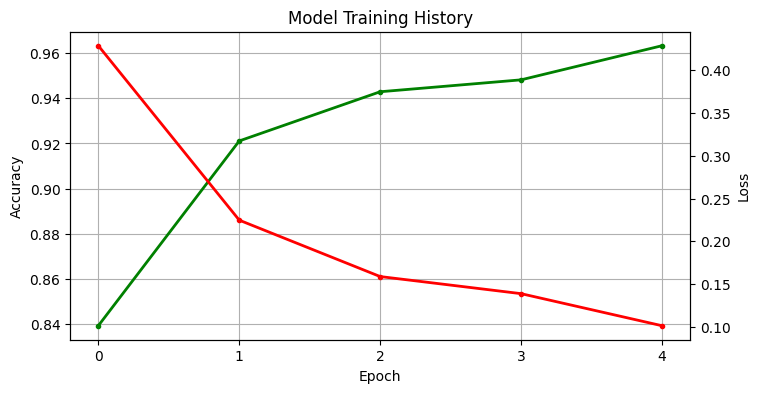

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.grid(True)

# Accuracy
ax1.plot(history_m3.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y')

# Loss
ax2 = ax1.twinx()
ax2.plot(history_m3.history['loss'], '.r-', linewidth=2)
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y')
plt.title('Model Training History')
ax1.set_xticks(range(epochs))
plt.show()


In [ ]:

evaluate_model(model_m3, test_images, test_labels_encoded, "reseNet50")

41/41 ━━━━━━━━━━━━━━━━━━━━ 235s 6s/step

Classification Report – reseNet50
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       300
           1       0.94      0.95      0.95       300
           2       0.93      0.99      0.96       405
           3       0.97      0.70      0.81       306

    accuracy                           0.91      1311
   macro avg       0.92      0.91      0.90      1311
weighted avg       0.92      0.91      0.91      1311



Confusion Matrix 3:
[[298   0   1   1]
 [ 50 199  10  41]
 [ 17  11 369   8]
 [125  12  49 120]]


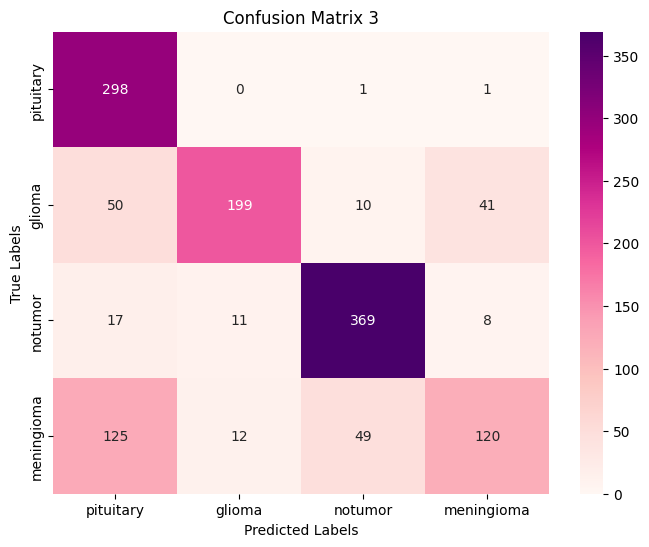

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix 3:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="RdPu", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix 3")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

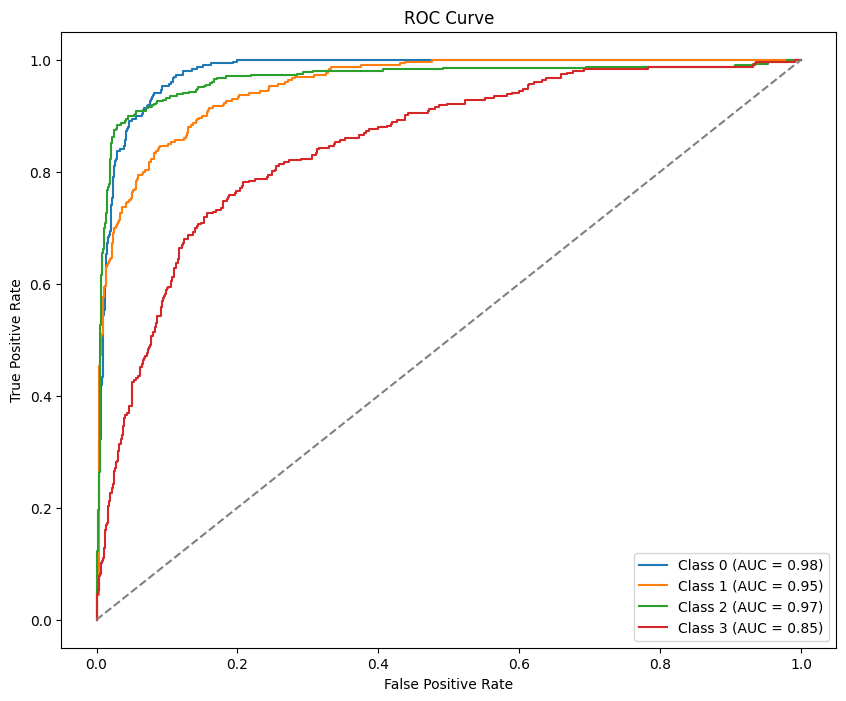

In [ ]:

test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the entire model
model_m3.save('model3.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


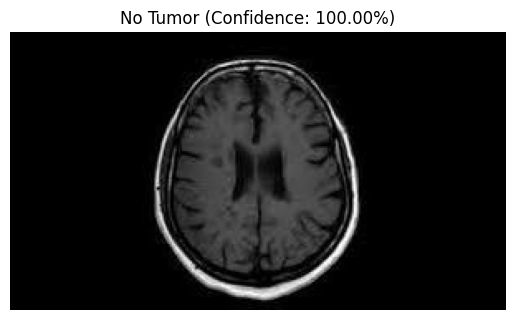

In [ ]:
detect_and_display(image_path, model_m3)

# PyTorch Model

In [ ]:
augmentation = transforms.Compose([
    transforms.RandomRotation(0.05),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


train_dl = DataLoader(datasets.ImageFolder(train_dir, augmentation),
                      batch_size=32,
                      shuffle=True,
                      num_workers=2,
                      pin_memory_device=True)

test_dl = DataLoader(datasets.ImageFolder(test_dir, augmentation),
                     batch_size=32,
                      shuffle=True,
                      num_workers=2,
                      pin_memory_device=True)

In [ ]:
start = time.perf_counter()

model_m5 = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(128 * 16 * 16, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(os.listdir(train_dir)))
    )

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_m5.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

end = time.perf_counter()
time_m5 = end - start

time_m5

0.15522170699841809

In [ ]:
model_m5.train()

for epoch in range(25):
    running_loss = 0.0   # RESET every epoch

    for x, y in train_dl:
        optimizer.zero_grad()

        outputs = model_m5(x)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}")

end = time.perf_counter()
time_m5 = end - start

time_m5

Epoch 1 - Loss: 0.7064
Epoch 2 - Loss: 0.5418
Epoch 3 - Loss: 0.4672
Epoch 4 - Loss: 0.4075
Epoch 5 - Loss: 0.3622
Epoch 6 - Loss: 0.3151


Testing save function

In [7]:
from pathlib import Path

model_path = Path("/content/gdrive/MyDrive/models/model_m1.keras")


In [8]:
model_m1 = load_model(model_path)

In [27]:
model_m1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,021,198 (122.15 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 16,257,290 (62.02 MB)

In [28]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

NameError: name 'test_labels_encoded' is not defined